## Imports

In [1]:
# data processing libraries
import pandas as pd
import pickle

# data modelling libraries
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# plot libraries
import seaborn as sns

# remove warning for clean notebook
import warnings
warnings.filterwarnings("ignore")

## Functions

In [2]:
# save X and y for modelling purpose
def get_X_y():
    
    X = []
    y = []
    
    with open('pickle/data_X.pickle', 'rb') as file:
        X = pickle.load(file)
        
    with open('pickle/data_y.pickle', 'rb') as file:
        y = pickle.load(file)
        
    return X, y

In [3]:
# returns scores for given models
def get_algorithm_scores(model_params):
    
    scores = []
    best_estimators = {}

    for algorithm, model_param in model_params.items():

        pipeline = make_pipeline(StandardScaler(), model_param['model'])
        classifier =  GridSearchCV(pipeline, model_param['params'], cv = 5, return_train_score = False)
        classifier.fit(X_train, y_train)

        scores.append({'model': algorithm,
                       'best_score': classifier.best_score_, 
                       'best_params' : classifier.best_params_})
        
        best_estimators[algorithm] = classifier.best_estimator_

    return scores, best_estimators

## Data Management

### Data Extraction

In [4]:
# get X and y
X, y = get_X_y()

# train and test split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

### Data Modelling

#### Try algorithms with simple parameters first before hypertuning
try various algorithms first before hyper tuning the paramteres to reduce calculation time

In [5]:
# various algorithms with standard parameters
model_params_simple = {'svc': {'model' : SVC(), 'params' : {}}, 
                       'svr': {'model' : SVR(), 'params' : {}},
                       
                       'random_forest': {'model': RandomForestClassifier(), 'params' : {}}, 
                       'decision_tree_classifier': {'model': DecisionTreeClassifier(), 'params' : {}}, 
                       'decision_tree_regressor': {'model': DecisionTreeRegressor(), 'params' : {}}, 
                       
                       'linear_regression' : {'model' : LinearRegression(), 'params' : {}},
                       'logistic_regression' : {'model': LogisticRegression(max_iter = 10000), 'params' : {}},
                       'lasso' : {'model' : Lasso(), 'params' : {}}}

In [6]:
# try simple algorithms and get the scores
simple_algo_scores, best_estimators = get_algorithm_scores(model_params_simple)

In [7]:
# convert and store the result to csv file
simple_algorithms_result = pd.DataFrame(simple_algo_scores, columns = ['model', 'best_score', 'best_params'])
simple_algorithms_result.sort_values(by = ['best_score'], ascending = False, inplace = True)
simple_algorithms_result.drop('best_params', axis = 1, inplace = True)
simple_algorithms_result.to_csv('00_simple_algos_result.csv')
simple_algorithms_result

,model,best_score
6,logistic_regression,0.694737
2,random_forest,0.678947
0,svc,0.652632
1,svr,0.482978
3,decision_tree_classifier,0.473684
5,linear_regression,0.392111
7,lasso,-0.014198
4,decision_tree_regressor,-0.277799


#### Hyper tune top 3 algorithms

In [8]:
model_params_tune = {
    'logistic_regression' : {
        'model': LogisticRegression(C = 1., max_iter = 10000),
        'params': {'logisticregression__solver' : ['lbfgs', 'liblinear', 'sag', 'saga'], 
                   'logisticregression__multi_class' : ['auto', 'ovr', 'multinomial']}},
                
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {'randomforestclassifier__n_estimators' : [50, 100, 250], 
                    'randomforestclassifier__criterion' : ['gini', 'entropy']}},
    'svc': {
        'model' : SVC(probability = True),
        'params' : {'svc__C': [1, 10, 100, 1000],
                    'svc__kernel': ['rbf','sigmoid'], 
                    'svc__gamma' : ['auto', 'scale']}}
}

In [9]:
# try simple algorithms and get the scores
tuned_algo_scores, best_estimators = get_algorithm_scores(model_params_tune)

In [10]:
# convert and store the result to csv file
tuned_algorithms_result = pd.DataFrame(tuned_algo_scores, columns = ['model', 'best_score', 'best_params'])
tuned_algorithms_result.sort_values(by = ['best_score'], ascending = False, inplace = True)
tuned_algorithms_result.to_csv('01_tuned_algos_result.csv')
tuned_algorithms_result

,model,best_score,best_params
0,logistic_regression,0.747368,"{'logisticregression__multi_class': 'auto', 'l..."
2,svc,0.726316,"{'svc__C': 10, 'svc__gamma': 'auto', 'svc__ker..."
1,random_forest,0.710526,{'randomforestclassifier__criterion': 'entropy...


#### Test and Train Scores for top 3 Classifiers

In [11]:
print('logistics_reg test score:', best_estimators['logistic_regression'].score(X_test, y_test))
print('logistics_reg train score:', best_estimators['logistic_regression'].score(X_train, y_train))

logistics_reg test score: 0.8181818181818182
logistics_reg train score: 1.0


In [12]:
print('random_forest test score:', best_estimators['random_forest'].score(X_test, y_test))
print('random_forest train score:', best_estimators['random_forest'].score(X_train, y_train))

random_forest test score: 0.7727272727272727
random_forest train score: 1.0


In [13]:
print('SVC test score:', best_estimators['svc'].score(X_test, y_test))
print('SVC train score:', best_estimators['svc'].score(X_train, y_train))

SVC test score: 0.7727272727272727
SVC train score: 1.0


#### Best Classifier and Confusion Matrix

<AxesSubplot:>

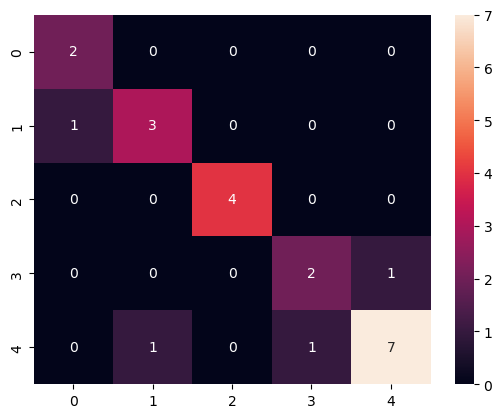

In [14]:
best_classifier = best_estimators['logistic_regression']

sns.heatmap(confusion_matrix(y_test, best_classifier.predict(X_test)), annot = True)